# **Deep Learning Advanced Model**

<ins>Group Members</ins>: Catrina Hacker, Yoonduk Kim, Mohit Bagri

This notebook contains the code for the deep learning advanced model. Our  model is trained to do ternary classification of images to assign labels of: 

*   0: no mask
*   1: correctly worn mask
*   2: incorrectly worn mask

The model takes an image and passes it through a pre-trained binary classifier (mask or no mask) to get a probability that a given image contains a mask. We also use non-DL methods to extract facial features for the image. The combined output of the binary classifier and facial features is then passed into a simple MLP which performs the ternary classification. The following notebook contains the code to train and test this model.  



#**Imports**

In [1]:
import pandas as pd
import os
import numpy as np
import joblib

import torch
import random
import albumentations
import matplotlib.pyplot as plt
import argparse
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from PIL import Image, ImageDraw
from tqdm import tqdm
from torchvision import models as models
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

import tqdm
from IPython import display

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Data Set Up**

In [3]:
img_dir = '/content/drive/My Drive/Colab Notebooks/CIS522- Deep Learning/Final Project/data/img/'
data_path = '/content/drive/My Drive/Colab Notebooks/CIS522- Deep Learning/Final Project/data/input/data.csv'
labels_dir = '/content/drive/My Drive/Colab Notebooks/CIS522- Deep Learning/Final Project/data/input/lb.pkl'

lb = joblib.load(labels_dir)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [4]:
def seed_everything(SEED=1337):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True

In [5]:
def norm_mean_std(X, img_size):
    images = []

    img_means = []
    img_stds = []

    resize = albumentations.Compose(
        [albumentations.Resize(img_size, img_size, always_apply=True)]
    )

    for i, img_path in tqdm(enumerate(X), total=len(X)):
        image = Image.open(img_path)
        image = image.convert("RGB")
        image = resize(image=np.array(image))

        images.append(image["image"])

    img_np = np.stack(images, axis=0)

    print(img_np.shape)
    # (10000, 256, 256, 3)

    for i in range(3):
        img_means.append(np.mean(img_np[:, :, :, i]))
        img_stds.append(np.std(img_np[:, :, :, i]))

    # divide means and stds by 255
    img_means = np.asarray(img_means) / 255
    print(img_means)

    img_stds = np.asarray(img_stds) / 255
    print(img_stds)

    return img_means, img_stds


In [6]:
# image dataset module
class ImageDataset(Dataset):
    def __init__(self, path, labels, img_size, train=True):
        # precomputed values for image normalization
        self.img_means = [0.5243259, 0.47015686, 0.45026454]
        self.img_stds = [0.29682344, 0.28559578, 0.28816244]

        self.X = path
        self.y = labels
        # apply augmentations
        if train:
            self.aug = albumentations.Compose(
                [
                    albumentations.Resize(img_size, img_size, always_apply=True),
                    albumentations.HorizontalFlip(p=1.0),
                    albumentations.ShiftScaleRotate(
                        shift_limit=0.3, scale_limit=0.3, rotate_limit=30, p=1.0
                    ),
                    albumentations.Normalize(
                        mean=self.img_means, std=self.img_stds, always_apply=True
                    ),
                ]
            )
        else:
            self.aug = albumentations.Compose(
                [
                    albumentations.Resize(img_size, img_size, always_apply=True),
                    albumentations.Normalize(
                        mean=self.img_means, std=self.img_stds, always_apply=True
                    ),
                ]
            )

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        image = Image.open(self.X[i])
        image = image.convert("RGB")
        image = self.aug(image=np.array(image))["image"]
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        label = self.y[i]
        return (
            torch.tensor(image, dtype=torch.float),
            torch.tensor(label, dtype=torch.long),
        )

In [7]:
SEED = 1337
seed_everything(SEED=SEED)
img_size = 256
test_size = 0.2
batch_size = 32

# set computation device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Computation device: {device}")

# read the data.csv file and get the image paths and labels
df = pd.read_csv(data_path)[:2000]

df['image_path'] = img_dir + df['image_path'].str[12:]

X = df.image_path.values
y = df.target.values

(xtrain, xtest, ytrain, ytest) = train_test_split(
    X, y, test_size=test_size, random_state=SEED)

train_data = ImageDataset(xtrain, ytrain, img_size=img_size, train=True)
test_data = ImageDataset(xtest, ytest, img_size=img_size, train=False)

trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Computation device: cuda:0


#**Binary mask classification**

In [8]:
class AlexNet(nn.Module):
    """
    Implementation from https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py
    """
    def __init__(self, num_classes: int = 2) -> None:
        super(AlexNet, self).__init__()

        # Convolutional Part
        self.convolutions = nn.Sequential(
            nn.Conv2d(3, 64, 11, 4, padding=2), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, 5, 2, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, 3, 2, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, 1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.AdaptiveAvgPool2d((6, 6))
        )

        # Fully-connected part
        self.fully_connected = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 2)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.convolutions(x)
        x = torch.flatten(x, 1)
        x = self.fully_connected(x)

        prob= nn.functional.softmax(x)

        return x, prob

In [9]:
alexnet = AlexNet().to(device)
optimizer = optim.Adam(alexnet.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()

test_accuracies = []
train_accuracies = []

pretrained_binary_path = "/content/drive/My Drive/Colab Notebooks/CIS522- Deep Learning/Final Project/data/input/model.pth"
alexnet = torch.load(pretrained_binary_path)

alexnet.eval()

mask_probs_test = torch.empty((0)).to(device)
for batch in tqdm.notebook.tqdm(testloader):
        image, labels = batch
        image = image.to(device)
        labels = labels.to(device)
        
        output, prob = alexnet(image)
        mask_probs_test = torch.cat((mask_probs_test, prob))

prob_mask_test = mask_probs_test[:, 0]

mask_probs_train = torch.empty((0)).to(device)
for batch in tqdm.notebook.tqdm(trainloader):
        image, labels = batch
        image = image.to(device)
        labels = labels.to(device)
        
        output, prob = alexnet(image)
        mask_probs_train = torch.cat((mask_probs_train, prob))

prob_mask_train = mask_probs_train[:, 0]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [10]:
print(prob_mask_test.shape)
print(prob_mask_train.shape)

torch.Size([60])
torch.Size([240])


#**Facial feature extraction**

Currently only working with haar features

In [11]:
dlib_encodings_path = "/content/drive/My Drive/Colab Notebooks/CIS522- Deep Learning/Final Project/data/input/dlib_encodings_v2.pickle"
haar_encodings_path = "/content/drive/My Drive/Colab Notebooks/CIS522- Deep Learning/Final Project/data/input/haar_encodings_v2.pickle"

# dlib = joblib.load(dlib_encodings_path)
# haar = joblib.load(haar_encodings_path)
!pip3 install pickle5
import pickle5 as pickle
with open(dlib_encodings_path, "rb") as fh:
  dlib = pickle.load(fh)

with open(haar_encodings_path, "rb") as fh:
  haar = pickle.load(fh)

for col in dlib.columns:
    print(col)
print(dlib.head)

for col in haar.columns:
    print(col)
print(haar.head)

dlib['file_path_col'] = img_dir + dlib['file_path_col'].str[12:]
haar['file_path'] = img_dir + haar['file_path'].str[12:]


     |████████████████████████████████| 133kB 11.3MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219242 sha256=4841244c87d592f9552d0d5ccb3c16de8de133fecdc2d2d418a60a77ba610e99
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5
file_path_col
face_locations_col
num_faces_col
face_landmarks_col
face_encodings_col
dlib_encoding_input
<bound method NDFrame.head of                           file_path_col  ...                                dlib_encoding_input
0    ../data/img/c3-incorrect/iw_19.jpg  ...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1    ../data/img/c3-incorrect/iw_47.png  ...  [-0.1256428062915802, 0.09607420861721039, 0.1...
2       ../data/img/c1-nomask/60047.png  ...  [-0.1463397741317749, -0.022170623764395714, -...
3       ../data/img/c1-nomask/60023.png  ...  [-0.05725245922803879, 0.040405020117759705, -...
4       ../data/img/c1-nomask/

In [12]:
train_paths = train_data.X
test_paths = test_data.X

no_feat_cnt = 0

# Loop through train loader and get encodings for that image 
train_combined = torch.empty((1,10))

cnt = 0
for curr_img_path in train_paths:
  curr_vals = haar[haar['file_path'].str.match(curr_img_path)]
  curr_is_face = np.reshape(curr_vals.iloc[0]['is_face'], (1,1))
  curr_nose = np.reshape(replace_nans(curr_vals['nose'][0]), (1,4))
  curr_mouth = np.reshape(replace_nans(curr_vals['mouth'][0]), (1,4))

  curr_combined = torch.from_numpy(np.concatenate((curr_is_face, curr_nose, curr_mouth), axis=1))
  curr_prob = prob_mask_train[cnt].detach()
  temp = curr_prob.item() 
  temp = torch.tensor([temp], dtype=torch.float64)
  temp = torch.reshape(temp, (1,1))
  curr_combined = torch.cat((curr_combined, temp), dim=1)

  train_combined = torch.cat((train_combined, curr_combined), dim=0)

  cnt += 1

train_combined = train_combined[1:, :]

# Loop through the test loader and get encodings for that image
test_combined = torch.empty((1, 10))
cnt = 0
for curr_img_path in test_paths:
  curr_vals = haar[haar['file_path'].str.match(curr_img_path)]
  curr_is_face = np.reshape(curr_vals.iloc[0]['is_face'], (1,1))
  curr_nose = np.reshape(replace_nans(curr_vals['nose'][0]), (1,4))
  curr_mouth = np.reshape(replace_nans(curr_vals['mouth'][0]), (1,4))

  curr_combined = torch.from_numpy(np.concatenate((curr_is_face, curr_nose, curr_mouth), axis=1))
  curr_prob = prob_mask_train[cnt].detach()
  temp = curr_prob.item() 
  temp = torch.tensor([temp], dtype=torch.float64)
  temp = torch.reshape(temp, (1,1))
  curr_combined = torch.cat((curr_combined, temp), dim=1)
  
  test_combined = torch.cat((test_combined, curr_combined), dim=0)

  cnt += 1

test_combined = test_combined[1:, :]

#**Generate new dataloaders**

In [13]:
class NewDataset(Dataset):
    def __init__(self, x, y, paths):
        super(NewDataset, self).__init__()
        assert x.shape[0] == y.shape[0] # assuming shape[0] = dataset size
        self.x = x
        self.y = y
        self.path = paths

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [14]:
SEED = 1337
seed_everything(SEED=SEED)
img_size = 17
test_size = 0.2
batch_size = 5

# set computation device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Computation device: {device}")

train_data_new = NewDataset(train_combined, train_data.y, train_data.X)
test_data_new = NewDataset(test_combined, test_data.y, test_data.X)

trainloader_new = DataLoader(train_data_new, batch_size=batch_size, shuffle=True)
testloader_new = DataLoader(test_data_new, batch_size=batch_size, shuffle=False)

Computation device: cuda:0


#**Final Model**

(Adapted from Week 3 homework)


In [25]:
class FinalNet(nn.Module):
    # def __init__(self, num_inputs, hidden_units, num_outputs):
    def __init__(self):
        super(FinalNet, self).__init__()

        self.fc1 = nn.Linear(10, 36)
        self.fc2 = nn.Linear(36, 12)
        self.fc3 = nn.Linear(12, 3)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))

        return x

In [16]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [28]:
def train_test_classification(net, criterion, optimizer,
                              train_loader, test_loader,
                              num_epochs=1, verbose=True,
                              training_plot=True):
  

  net.train()
  training_losses = []
  test_accuracies = []
  train_accuracies = []
  for epoch in range(num_epochs):  # loop over the dataset multiple times
      print("epoch ", epoch)
      running_loss = 0.0
      for i, data in enumerate(train_loader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          inputs = inputs.to(device).float()
          labels = labels.to(device).long()

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)

          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          if verbose:
            training_losses += [loss.item()]
            running_loss += loss.item()
      
      # Eval loop
      net.eval()
      train_total_correct = 0
      for i, data in enumerate(train_loader, 0):
          inputs, labels = data
          inputs = inputs.to(device).float()
          labels = labels.to(device).long()
          
          output = net(inputs)
          train_predictions = torch.argmax(output, dim=1)
          train_num_correct = torch.sum(train_predictions == labels)
          train_total_correct += train_num_correct

      test_total_correct = 0
      for i, data in enumerate(test_loader, 0):
          inputs, labels = data
          inputs = inputs.to(device).float()
          labels = labels.to(device).long()
          
          output = net(inputs)
          test_predictions = torch.argmax(output, dim=1)
          test_num_correct = torch.sum(test_predictions == labels)
          test_total_correct += test_num_correct

      # Visualize accuracy
      test_accuracy = test_total_correct / len(test_data)
      test_accuracies.append(test_accuracy.item()) 
      train_accuracy = train_total_correct / len(train_data)
      train_accuracies.append(train_accuracy.item())

  plt.plot(train_accuracies, label='train')
  plt.plot(test_accuracies, label='test')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Prediction Accuracy')
  plt.legend()
  plt.show()

epoch  0
epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9
epoch  10
epoch  11
epoch  12
epoch  13
epoch  14
epoch  15
epoch  16
epoch  17
epoch  18
epoch  19


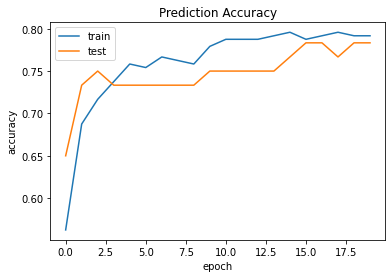

In [43]:
net = FinalNet().to(device)
criterion =  torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4, weight_decay=0.2)
train_acc = train_test_classification(net, criterion, optimizer,
                                      trainloader_new, testloader_new,
                                      num_epochs=20)

In [32]:
def confusion_matrix(preds, labels):
  # Produces a confusion matrix for the output of a test batch
  # Args:
    # preds (tensor): predictions from model output
    # labels (tensor): ground-truth labels
  # Returns: 
    # None

  # Generate values for confusion matrix
  nomask = np.zeros((1, 3))
  correct = np.zeros((1, 3))
  incorrect = np.zeros((1, 3))
  cnt = 0
  for prediction, label in zip(preds, labels):
    prediction = int(prediction)
    label = int(label)
    if label == 0: # no mask
      nomask[0, prediction] += 1 
    elif label == 1: # correctly worn
      correct[0, prediction] += 1
    elif label == 2: # incorrectly worn
      incorrect[0, prediction] += 1
  
  confusion_matrix = np.concatenate((nomask/np.sum(nomask), correct/np.sum(correct), incorrect/np.sum(incorrect)))
  confusion_matrix = confusion_matrix
  print(confusion_matrix)

  # Plot
  sns.heatmap(confusion_matrix, annot=True, fmt='.2f')
  plt.ylabel('label')
  plt.xlabel('prediction')
  plt.xticks([0.5, 1.5, 2.5], ['no mask', 'correct', 'incorrect'])
  plt.yticks([0.5, 1.5, 2.5], ['no mask', 'correct', 'incorrect'], verticalalignment='center')

In [44]:
net.eval()
correct = 0
total = 0
all_preds = torch.empty((0)).to(device)
all_labels = torch.empty((0)).to(device)
for data in tqdm.notebook.tqdm(testloader_new):
    inputs, labels = data
    inputs = inputs.to(device).float()
    labels = labels.to(device).long()

    outputs = net(inputs)
    _, predicted = torch.max(outputs, 1)
    all_preds = torch.cat((all_preds, predicted), dim=0)
    all_labels = torch.cat((all_labels, labels), dim=0)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

acc = 100 * correct / total

Test accuracy: 78.33%
0.7833333333333333
[[0.90909091 0.04545455 0.04545455]
 [0.         1.         0.        ]
 [0.05882353 0.58823529 0.35294118]]


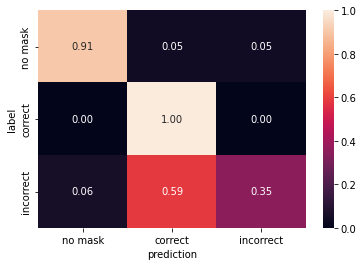

In [45]:
print('Test accuracy: %.2f%%' % (acc))

from sklearn.metrics import f1_score

print(f1_score(all_labels.cpu().numpy(), all_preds.cpu().numpy(), average='micro'))

confusion_matrix(all_preds.cpu().numpy(), all_labels.cpu().numpy())

In [46]:
test_paths = test_data_new.path
is_face_all = haar['is_face'].to_numpy()

correctly_classified = []
correctly_classified_face = np.empty(0)
correct_prob = np.empty(0)
incorrectly_classified = []
incorrectly_classified_face = np.empty(0)
incorrect_prob = np.empty(0)
cnt = 0
for prd, lbl in zip(all_preds, all_labels):
  if prd == lbl:
    correctly_classified.append(test_paths[cnt])
    correctly_classified_face = np.append(correctly_classified_face, is_face_all[cnt])
    correct_prob = np.append(correct_prob, test_data_new.x[cnt,9])
  else:
    incorrectly_classified.append(test_paths[cnt])
    incorrectly_classified_face = np.append(incorrectly_classified_face, is_face_all[cnt])
    incorrect_prob = np.append(incorrect_prob, test_data_new.x[cnt,9])
  
  cnt += 1

print(correctly_classified_face.shape)
print('Correctly Classified')
# %pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
cnt = 0
for img in correctly_classified:
  curr_img = mpimg.imread(img)
  imgplot = plt.imshow(curr_img)
  plt.show()
  print(correctly_classified_face[cnt])
  print(correct_prob[cnt])
  cnt += 1
  print('')

print('---------------')

cnt = 0
print('Incorrectly Classified')
for img in incorrectly_classified:
  curr_img = mpimg.imread(img)
  imgplot = plt.imshow(curr_img)
  plt.show()
  print(incorrectly_classified_face[cnt])
  print(incorrect_prob[cnt])
  cnt += 1
  print('')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
is_face_all = haar['is_face'].to_numpy()

cnt = 0
for prd, lbl in zip(all_preds, all_labels):
  if prd == lbl:
    correctly_classified.append(test_paths[cnt])
  else:
    incorrectly_classified.append(test_paths[cnt])
  
  cnt += 1

[1 1 1 0 1 1 1 0 0 0 0 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 0 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 0 1 1 0 1 1 0 1 0 1
 1 0 1 1 0 1 0 1 0 0 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0
 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 1 0 1 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 0 0
 1 0 0 1 1 0 0 1 0 1 1 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 1 0 1 1 0 1 1 1 0 0 1
 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1
 0 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 0 0 0 1 1 0 0 1 1 0 0 1 1 0 1
 1 1 1 1]


In [59]:
fc1_weights = net.fc1.weight.detach().cpu().numpy()

sum_prob_weights = np.zeros((1, 10))
for node in fc1_weights:
  sum_prob_weights += node

print(sum_prob_weights)

[[ 0.04007183  1.20730537  0.84685054  0.79671543 -0.22794832  1.20833344
   1.56401262 -0.31126117  0.69219913  0.1396305 ]]
